# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1</center>
## <center>Checkpoint 2 : Árbol de decisión</center> 

# Consigna


1.   Construir árboles de decisión y optimizar sus hiperparámetros mediante k-fold Cross Validation para obtener la mejor performance. **¿Cuántos folds utilizaron?¿Qué métrica consideran adecuada para buscar los parámetros?**
2.   Graficar el árbol de decisión con mejor performance encontrado en el punto
anterior. Si es muy extenso mostrar una porción representativa.
3.   **Analizar el árbol de decisión seleccionado describiendo los atributos elegidos, y decisiones evaluadas (explicar las primeras reglas obtenidas).**
4.   Evaluar la performance del modelo en entrenamiento y validación, explicar todas
las métricas y mostrar la matriz de confusión.
5.   Generar predicciones con el conjunto de test y realizar los submits
correspondientes en la competencia de Kaggle.

# Inicializacion de entorno

## Librerías

In [ ]:
!pip install dtreeviz
!pip install geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 42.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sklearn as sk
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.model_selection import (
    StratifiedKFold,
    KFold,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import (LinearRegression, LogisticRegressionCV)
from sklearn.ensemble import (IsolationForest, RandomForestClassifier, GradientBoostingRegressor)
from sklearn import tree
from sklearn.tree import (DecisionTreeClassifier, export_graphviz)
from sklearn import metrics
from sklearn.metrics import (
    make_scorer,
    confusion_matrix,
    auc,
    log_loss,
    r2_score,
    silhouette_score,
    recall_score, 
    accuracy_score, 
    f1_score,
)
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor

import dtreeviz.trees as dtreeviz
from tqdm import tqdm
from joblib import dump, load
from xgboost import XGBRegressor
from subprocess import call
from IPython.display import Image
from sklearn.decomposition import PCA

from datetime import datetime

import shapely
#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz.trees as dtreeviz

#modelos y métricas
from sklearn import preprocessing, tree
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report
#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


## Datasets

In [ ]:
db_train_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/hotels_train_clean.csv'
db_test_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/hotels_test_complete.csv'
df_train = pd.read_csv(db_train_url)
df_test_submission = pd.read_csv(db_test_url)

## Funciones

In [ ]:
def metricas_modelo(test, pred):
  #Calculo las métricas en el conjunto de evaluación
  accuracy=accuracy_score(test, pred)
  recall=recall_score(test, pred)
  f1=f1_score(test, pred)
  precision=precision_score(test, pred)

  print("Accuracy: "+str(accuracy))
  print("Recall: "+str(recall))
  print("Precision: "+str(precision))
  print("f1 score: "+str(f1))

  tabla=confusion_matrix(test, pred)

  #Grafico la matriz de confusión
  sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')


La métricas para evaluar el rendimiento de un modelo se calculan comparando los valores predichos frente a los reales en un conjunto de testeo, es así que surgen diferentes valores:

*   **Matriz de confusión**:


|            | predicted    |            |            |
|:----------:|:------------:|:----------:|:----------:|
|            |              |      0     |       1    |
| real       |0             | TN         | FP         |
|            |1             | FN         | TP         |

**TN**: True Negative; **FN**: False Negative; **FP**: False Positive; **TP**: True Positive



---


*   **Precisión** (precision):
    \begin{align}
        precision=\frac{TP}{TP+FP}
    \end{align}

    La *precisión* indica que cuanto más se acerca a 1, menos falsos positivos tuvo y por lo tanto todos las predicciones sobre la positiva fueron correctas. Esta métrica valora la calidad del modelo.


---


*   **Exhaustividad** (recall):
    \begin{align}
        recall=\frac{TP}{TP+FN}
    \end{align}

    Si el *exhaustividad* se acerca a 1, quiere decir que no se quedó ningún negativo verdadero afuera. Esta métrica valora la cantidad de valores que pueden identificar del modelo. 


---


*   **F1**:
    \begin{align}
        F1=2.\frac{precision.recall}{precision+recall}
    \end{align}

    *F1* se utiliza para combinar las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de ambas métricas.


---


*   **Exactitud** (accuracy):
\begin{align}
    accuracy=\frac{TP+TN}{TP++TN+FP+FN}
\end{align}

  La *exactitud* indica cual es el porcentaje de aciertos del modelo. Sin embargo no brinda mucha información sobre cómo se distribuyen los valores.

    

# Preprocesamiento del dataframe

In [ ]:
df_work_train = df_train.copy()
df_work_test_submission = df_test_submission.copy()

## Limpieza de columnas irrelevantes

Se eliminan columnas nulas o irrelevantes detectadas en el analisis exploratorio

In [ ]:
# Id es irrelevante
# reservation_status_date delata el resultado del target y
# assigned_room_type y reserved_room_type, consideramos que tiene su información relevante condensada en misassigned_room
columnas_para_eliminar = ['id', 'assigned_room_type', 'reserved_room_type']

df_work_train.drop(columnas_para_eliminar, axis='columns', inplace=True)
df_work_test_submission.drop(columnas_para_eliminar, axis='columns', inplace=True)

## Label encoding

Se encodean con Label encoding `assigned_room_type`, `reserved_room_type` y `country`

In [ ]:
columns_to_encode = ['country']

le = LabelEncoder()
for column in columns_to_encode:  
  df_work_train[column] = le.fit_transform(df_work_train[column].astype(str))
  df_work_test_submission[column] = le.fit_transform(df_work_test_submission[column].astype(str))


In [ ]:
df_work_train[columns_to_encode]

,country
0,143
1,113
2,22
3,113
4,46
...,...
55381,41
55382,46
55383,46
55384,113


## Normalización por z-score

Se normaliza por z-score la variable cuantiativa continua `adr` 

In [ ]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler() 
adr_z_score = standard_scaler.fit_transform(df_work_train['adr'].to_frame())

std=df_work_train['adr'].std()
mean=df_work_train['adr'].mean()

df_work_train['adr']=(df_work_train['adr']-mean)/std

In [ ]:
df_work_train['adr']

0        0.316512
1       -1.379487
2        2.935503
3       -0.618018
4       -0.618018
           ...   
55381   -1.241038
55382    1.089518
55383   -0.156522
55384   -1.516782
55385    0.957761
Name: adr, Length: 55386, dtype: float64

Como la normalización no debería modificar la distribución, graficamos un histograma de `adr` para corroborarlo

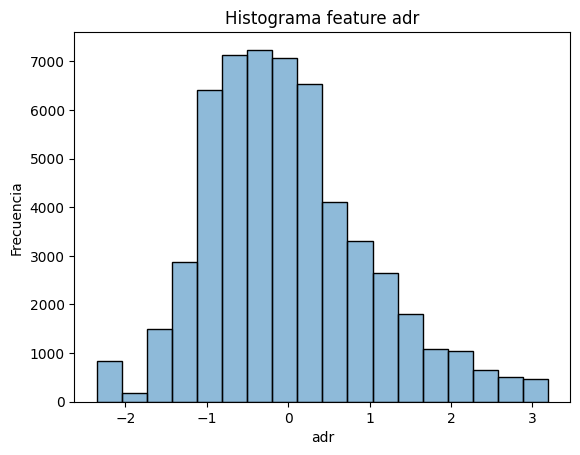

In [ ]:
sns_hist=sns.histplot(data=df_work_train['adr'], alpha = 0.5, bins=18).set(title="Histograma feature adr",xlabel="adr",ylabel="Frecuencia")
plt.show()

## One Hot encoding

Para aquellas **variables cualitativas de texto** que presentan los mismos valores tanto en el train como en el test, utitilizamos *One Hot Encoding* para que puedan ser procesadas por los modelos

In [ ]:
columnas_dummies = [
    "arrival_date_month",    
    "hotel",
    "deposit_type",
    "customer_type",
    "meal",
    "market_segment",
    "distribution_channel",
]

df_work_train = pd.get_dummies(df_work_train, columns=columnas_dummies, drop_first=True)
df_work_test_submission = pd.get_dummies(df_work_test_submission, columns=columnas_dummies, drop_first=True)

Se eliminan aquellas variables dummies que contienen informacion redundante

## Separación en x e y

Separacion entre columnas de decision y de target

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
x_work = df_work_train.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
y_work = df_work_train['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x_work,
                                                    y_work, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

x_test_submission = df_work_test_submission.copy()                                               

# Entrenamiento y Predicción

### Árbol sin optimizaciones

In [ ]:
tree_model_basic = tree.DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 5, 
                                         min_samples_leaf=10) 
#Entrenamos el modelo
model_basic = tree_model_basic.fit(X = x_train, y = y_train)

Accuracy: 0.7217140105922003
Recall: 0.8297387970285166
Precision: 0.6837480252764613
f1 score: 0.7497022842914367


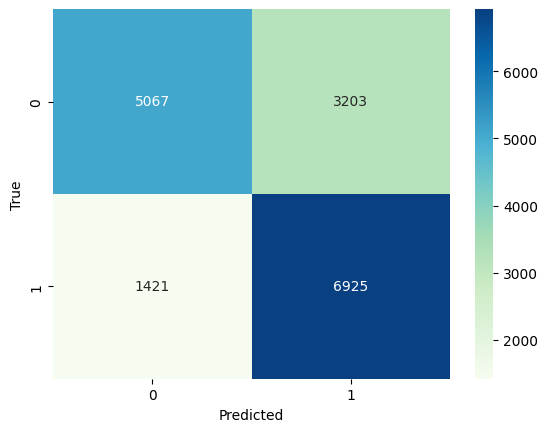

In [ ]:
#Realizamos una predicción sobre el set de test
y_pred_basic = model_basic.predict(x_test)
metricas_modelo(y_test, y_pred_basic)

### Árbol optimizado con CrossValidation

Buscamos los mejores hiperparámetros para el modelo mediante k-fold CrossValidation para obtener la mejor performance.

Decidimos buscar hiperparámetros que optimizaran accuracy ya que nos pareció la métrica más adecuada.

Realizamos 20 iteraciones para buscar los mejores hiperparámetros, y dividimos el dataset en 5 folds para el Cross Validation. Elegimos usar 5 ya que nos pareció que es una cantidad razonable de subconjuntos.


In [ ]:
n_combinations = 20

params = {
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": list(range(1, 10)),
    "ccp_alpha": np.linspace(0, 0.05, n_combinations),
    "max_depth": list(range(1, 1000)),
    'random_state': [0]
}

folds = 5


In [ ]:
kfoldcv = StratifiedKFold(n_splits=folds)

base_tree = DecisionTreeClassifier()

score = make_scorer(sk.metrics.accuracy_score)

randomcv = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions=params,
    scoring=score,
    cv=kfoldcv,
    n_iter=n_combinations,
    random_state=0
)

randomcv.fit(X=x_train, y=y_train)

print("Mejores hiperparámetros: ", randomcv.best_params_)
print("Mejor métrica: ", randomcv.best_score_)

Mejores hiperparámetros:  {'random_state': 0, 'min_samples_leaf': 8, 'max_depth': 900, 'criterion': 'entropy', 'ccp_alpha': 0.0}
Mejor métrica:  0.8284498323445962


Se inicializa el arbol según su mejor optimización

In [ ]:
tree_model_op = randomcv.best_estimator_

model_cross_validation = tree_model_op.fit(X=x_train, y=y_train)

Se hace una predicción con nuestro conjunto de test y se toman las métricas

Accuracy: 0.8350987000481463
Recall: 0.8248262640786005
Precision: 0.8434207302131831
f1 score: 0.8340198691543494


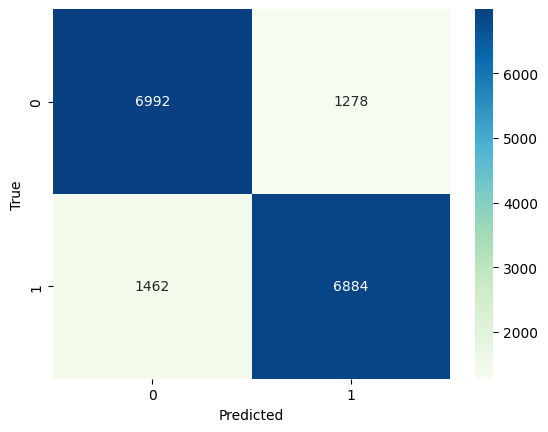

In [ ]:
y_pred = model_cross_validation.predict(x_test)
metricas_modelo(y_test, y_pred)

# Gráfico del modelo optimizado

In [ ]:
plt.figure(figsize=(100,100))

tree_plot_completo=tree.plot_tree(model_cross_validation,
                                  max_depth = 2,
                                 feature_names=x_train.columns.to_list(),
                                 filled=True,
                                 rounded=True,
                                 class_names= True) #model.classes_
plt.show(tree_plot_completo)



Como podemos observar, el árbol primero pregunta si Non refun en deposit_type es menor que 0.5. Si esto se cumple, se generan dos ramas, una pregunta si misassigned_room es menor a 0.5 y si country es menor a 38.

Luego, se generan 4 subramas: en una se pregunta por los required_car_parking_spaces es menor a 0.5, en otra si la variable country es menor a 65.5, la otra si la variable arrival_date_week_number es menor a 22 y la última si en la variable customer_type aparece Transient-party menos de 0.5

Así sigue generando las ramas hasta que termina de clasificar todas las observaciones.


# Submission

Se realiza una prediccion a partir de las columnas de decision del dataframe de test

In [ ]:
y_pred = model_cross_validation.predict(x_test_submission)
df_submission = pd.DataFrame({"id": df_test_submission["id"], "is_canceled": y_pred})
df_submission

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,0
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,0


In [ ]:
from google.colab import files

file_name = 'submission ' + datetime.now().strftime("%d-%m %H:%M:%S") + '.csv'
df_submission.to_csv(file_name, encoding = 'utf-8-sig', index=False) 
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>